In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../runs/results.csv')
df = df.replace({'apply_patch': 'True', 'random_patch': 'True'}, 1)
df = df.replace({'apply_patch': 'False', 'random_patch': 'False'}, 0)
for col in ['apply_patch', 'random_patch']:
    df[col] = df[col].astype(float).astype(bool)

# df[['fnr_octagon', 'num_targets_octagon', 'total_num_patches', 'fn_octagon', 'apply_patch', 'no_transform', 'no_relighting']].tail(5)
df[['fnr_octagon', 'num_targets_octagon', 'total_num_patches', 'fn_octagon', 'apply_patch', 'no_transform', 'no_relighting']].tail(5)

,fnr_octagon,num_targets_octagon,total_num_patches,fn_octagon,apply_patch,no_transform,no_relighting
5,0.142857,7.0,6.0,1.0,True,0.0,0.0
6,0.750000,4.0,3.0,3.0,True,False,False
7,0.309605,885.0,571.0,274.0,True,False,False
8,0.632768,885.0,571.0,560.0,True,False,False
9,0.128814,885.0,0.0,114.0,False,NaN,NaN


In [8]:
# f = open('../runs/val/exp/bg_filenames.txt', 'r')
# lines = f.readlines()
# bg_filenames = [x.strip('\n') for x in lines]
# print(bg_filenames)

df_results_per_label_no_patch = pd.read_csv('../runs/val/exp_mapillary_no_patch_0/results_per_label.csv')
df_results_per_label_rp2_patch = pd.read_csv('../runs/val/exp_mapillary_rp2_patch_0/results_per_label.csv')

merged_df = df_results_per_label_no_patch.merge(df_results_per_label_rp2_patch, on=['filename', 'obj_id', 'sign_width', 'sign_height'], suffixes=['_no_patch', '_patch'])
assert len(merged_df) == len(df_results_per_label_rp2_patch) & len(merged_df) == len(df_results_per_label_no_patch)

merged_df = merged_df[merged_df['correct_prediction_no_patch'] == 1]
merged_df = merged_df[merged_df['num_patches_applied_to_image_patch'] > 0]

merged_df['success_rate'] = merged_df['correct_prediction_no_patch'] - merged_df['correct_prediction_patch']
# successful_attack_filenames = set(merged_df[merged_df['change_in_fn'] > 0]['filename'])
# len(successful_attack_filenames_2)

# merged_df[merged_df['filename'].isin(bg_filenames)]

merged_df['avg_sign_dim'] = (merged_df['sign_width'] + merged_df['sign_height'])/2
merged_df['sign_area'] = merged_df['sign_width'] * merged_df['sign_height']
merged_df['change_in_confidence_after_patch'] = merged_df['confidence_patch'] - merged_df['confidence_no_patch']
merged_df = merged_df.sort_values(by=['success_rate', 'change_in_confidence_after_patch', 'filename'], ascending=[False, True, True])
merged_df

,filename,obj_id,label_no_patch,correct_prediction_no_patch,sign_width,sign_height,confidence_no_patch,num_patches_applied_to_image_no_patch,label_patch,correct_prediction_patch,confidence_patch,num_patches_applied_to_image_patch,success_rate,avg_sign_dim,sign_area,change_in_confidence_after_patch
192,_fafs0ETmuIe2cEr8oQHgA.jpg,0.0,14.0,1,62.857300,81.587341,0.926987,0.0,14.0,0,0.012583,1.0,1,72.222321,5128.359973,-0.914404
698,SWPikw9aQW6panoYMiH2ug.jpg,5.0,14.0,1,77.530823,77.037018,0.920700,0.0,14.0,0,0.037456,1.0,1,77.283920,5972.743374,-0.883243
481,mPS-BIj58jcEOtQIbEjfbg.jpg,0.0,14.0,1,75.501953,75.502045,0.914350,0.0,14.0,0,0.031555,1.0,1,75.501999,5700.551838,-0.882795
839,NMYrixO1v9rQh9CiI2s_rA.jpg,7.0,14.0,1,41.587311,40.317444,0.921884,0.0,14.0,0,0.048514,1.0,1,40.952377,1676.694068,-0.873371
105,wdWcNQ6NYVCnVqPjH4Z2ig.jpg,0.0,14.0,1,51.666748,53.666687,0.906985,0.0,14.0,0,0.041961,1.0,1,52.666718,2772.783196,-0.865024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,pWFy1P6EmpAiUtDU6CDO2A.jpg,7.0,14.0,1,20.784302,20.392090,0.831559,0.0,14.0,1,0.833745,3.0,0,20.588196,423.835349,0.002186
578,CYDq48nyNlpNd95K5xxTJQ.jpg,0.0,14.0,1,32.698364,32.380920,0.896797,0.0,14.0,1,0.899999,2.0,0,32.539642,1058.803131,0.003202
784,J-8nlLTMRhKGH1lokswIzQ.jpg,2.0,14.0,1,29.019651,45.882324,0.426313,0.0,14.0,1,0.433522,5.0,0,37.450988,1331.489055,0.007208
785,J-8nlLTMRhKGH1lokswIzQ.jpg,3.0,14.0,1,29.411804,44.705933,0.433121,0.0,14.0,1,0.442933,5.0,0,37.058868,1314.882137,0.009812


In [4]:
# merged_df['filename'][:10]
merged_df['filename'][-11:]

157    DoPjXGW708rikrhG3dMRmw.jpg
813    G1YCASdJSqcGhfzbAssm4A.jpg
884    gyRAEqKe8PWQHtmRiq1I9Q.jpg
654    3vpEdqkJcWQaEy2-zCXbyA.jpg
571    CvL_ooNj5fCC0JdI4oW3ew.jpg
691    RvITnZzvMWgea-RFFZqlgg.jpg
448    pWFy1P6EmpAiUtDU6CDO2A.jpg
578    CYDq48nyNlpNd95K5xxTJQ.jpg
784    J-8nlLTMRhKGH1lokswIzQ.jpg
785    J-8nlLTMRhKGH1lokswIzQ.jpg
243    ZRJFX8E6ls076pkO1-_mqg.jpg
Name: filename, dtype: object

In [5]:
# # checking results per label are correct
# df_results_per_image = pd.read_csv('../runs/val/exp_mapillary_rp2_patch_37/results_per_image.csv')
# print(np.sum(df_results_per_image['fn']))

# print(len(df_results_per_label_rp2_patch) - np.sum(df_results_per_label_rp2_patch['correct_prediction']))


In [6]:
print('patch success rate: ', np.round(np.sum(merged_df['success_rate'])/571, 3))

patch success rate:  0.296


(0.0, 1.0)

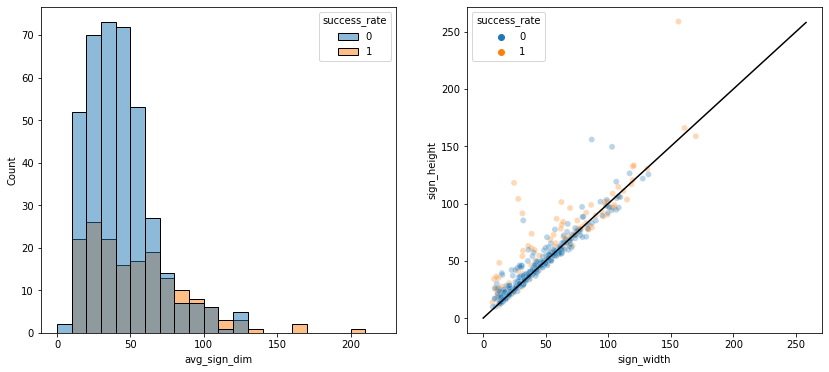

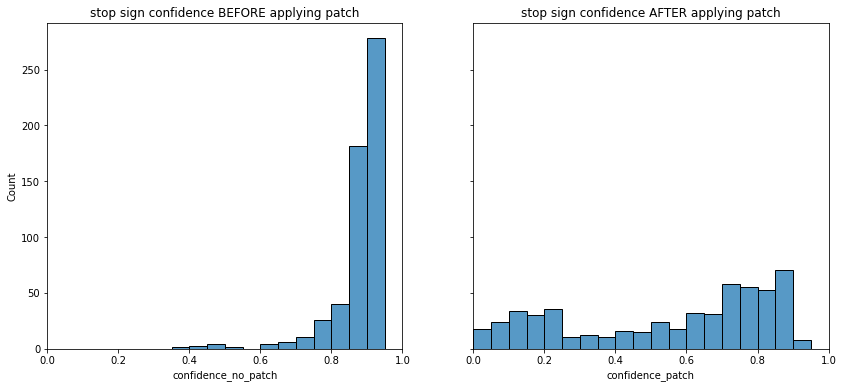

In [7]:
f, ax = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(14)

bins = np.arange(0, 226, 10)
sns.histplot(data=merged_df[merged_df['success_rate'] >= 0], x="avg_sign_dim", hue='success_rate', bins=bins, ax=ax[0])
sns.scatterplot(x='sign_width', y='sign_height', data=merged_df[merged_df['success_rate'] >= 0], hue='success_rate', alpha=0.3, ax=ax[1])
ax[1].plot(np.arange(0, max(merged_df[merged_df['success_rate'] >= 0]['sign_height'])), np.arange(0, max(merged_df[merged_df['success_rate'] >= 0]['sign_height'])), color='black')

f, ax = plt.subplots(1, 2, sharey=True)
f.set_figheight(6)
f.set_figwidth(14)
ax[0].set_title('stop sign confidence BEFORE applying patch')
ax[1].set_title('stop sign confidence AFTER applying patch')
bins=np.arange(0, 1.01, 0.05)
# sns.histplot(data=df_results_per_label_no_patch, x="confidence", ax=ax[0], bins=bins)
sns.histplot(data=merged_df, x="confidence_no_patch", ax=ax[0], bins=bins)
sns.histplot(data=merged_df, x="confidence_patch", ax=ax[1], bins=bins)

ax[0].set_xlim(0,1)
ax[1].set_xlim(0,1)

<AxesSubplot:xlabel='sign_area', ylabel='success_rate'>

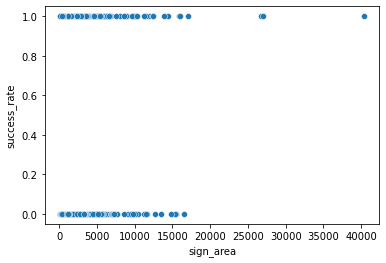

In [13]:
sns.scatterplot(x='sign_area', y='success_rate', data=merged_df[merged_df['success_rate'] >= 0])

In [12]:
successful_attack_filenames = set(merged_df[merged_df['fn'] > 0]['filename'])
len(successful_attack_filenames)

with open('../runs/successful_attack_filenames.txt', 'w') as f:
    for line in successful_attack_filenames:
        f.write(line)
        f.write('\n')
